In [1]:
from toolbox.models import ResNet112, ResNet56
from toolbox.data_loader import Cifar100

import torch
import torchvision
import torchvision.transforms as transforms

import tensorly as tl
import numpy as np
import matplotlib.pyplot as plt

from rich import print as pprint
from tqdm import trange

device = "cuda"
##########################

In [2]:
tl.set_backend("pytorch")
def tucker(feature_map): #expects 4d
    batch_size, channels, height, width = feature_map.shape
    core, factors = tl.decomposition.tucker(feature_map, rank=[batch_size, 32, 8, 8])
    return core


In [4]:
problem_fmap = torch.load("toolbox/problem_fm.pt", map_location=device, weights_only=True)
good_fmap = torch.load("toolbox/good_fm.pt", map_location=device, weights_only=True)

In [11]:
for fmap in problem_fmap:
    print(fmap.shape)


    break
    tuckered = tucker(fmap)

torch.Size([128, 64, 8, 8])


In [27]:
def visualize_processed_feature_map(feature_map):  # feature_map shape: [64,8,8]
    pprint(feature_map)
    feature_map = torch.mean(feature_map, dim=0, keepdim=True)  # Shape: [1, H, W]

    feature_map = feature_map.view(1, -1)  # Shape: [1, H*W]
    feature_map = torch.softmax(feature_map, dim=1)  # Shape: [1, H*W]
    feature_map = feature_map.view(8, 8).cpu()  # Shape: [H, W]

    plt.figure(figsize=(5, 5))
    plt.imshow(feature_map, vmin=0)
    plt.axis("off")
    plt.title(f"Processed Feature Map for sample")
    plt.show()

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]])

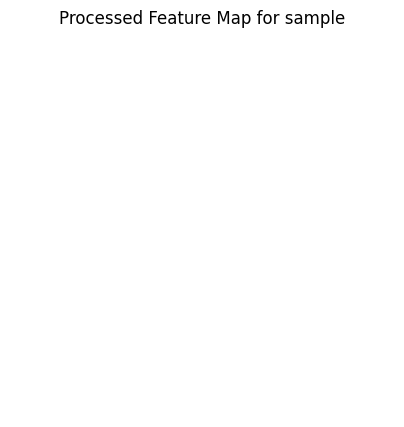

In [28]:

for i in range(128):
    visualize_processed_feature_map(fmap[i].cpu().detach())
    break

In [29]:
import torch
import torch.nn as nn
import tensorly as tl
from tensorly.tenalg import multi_mode_dot

tl.set_backend('pytorch')  # Ensure PyTorch backend is used

class DifferentiableTucker(nn.Module):
    def __init__(self, input_shape, ranks):
        """
        input_shape: Tuple of 4 dimensions (B, C, H, W)
        ranks: Tuple of 4 integers for core tensor dimensions (R_b, R_c, R_h, R_w)
        """
        super(DifferentiableTucker, self).__init__()
        self.input_shape = input_shape
        self.ranks = ranks

        # Create learnable core tensor
        self.core = nn.Parameter(torch.randn(*ranks))

        # Create learnable factor matrices for each mode
        self.factors = nn.ParameterList([
            nn.Parameter(torch.randn(input_dim, rank))  # input_dim x rank
            for input_dim, rank in zip(input_shape, ranks)
        ])

    def forward(self):
        # Reconstruct the tensor from the Tucker parameters
        x_reconstructed = multi_mode_dot(self.core, self.factors, modes=[0, 1, 2, 3])
        return x_reconstructed

In [30]:
input_shape = (4, 64, 32, 32)
ranks = (4, 32, 8, 8)

tucker_layer = DifferentiableTucker(input_shape=input_shape, ranks=ranks)
reconstructed = tucker_layer()

In [ ]:
import tensorly as tl
import torch

tl.set_backend('pytorch')

x = torch.randn(5, 5, 5, requires_grad=True)
core, factors = tl.decomposition.tucker(x, rank=[3, 3, 3])

# # Do some operation on core or reconstructed tensor
# from tensorly import tucker_to_tensor
# reconstructed = tucker_to_tensor((core, factors))
loss = core.sum()
loss.backward()

print(x.grad is not None)  # True if everything worked correctly


## CHECK MY LOSS FUNCTION< HY IS DALK FUNCKY

True
